In this lab we will tackle two tasks: 
  - image classification: what is the object in the center of a picture?
  - localisation: where is the object in a larger picture?

Firstly we will train a small convolutional network to classify digits on MNIST dataset. 
Then we will use this network as a starting point for a new model used to localise a digit in an image containing noise. This is an artificial task but it is a good example to investigate aspects of transfer learning. 

In other, more challenging tasks we can follow a similar aproach:
  - get a model trained on a simpler tasks, or a tasks where we have more data
  - use a part of the pretrained model and incorporate it into a model designed for current task
  - freeze the pretrained part or finetune it

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from IPython.core.debugger import set_trace
import numpy as np
from matplotlib import pyplot
# we need google drive access to upload the datasets
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Training settings    
kwargs={}
class Args():
  def __init__(self):
      self.batch_size = 64
      self.test_batch_size = 64
      self.epochs = 10
      self.lr = 0.01
      self.momentum = 0.9
      self.seed = 1
      self.log_interval = int(10000 / self.batch_size)
      self.cuda = False

args = Args()

use_cuda = torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In order to familiarize ourselfs with the operations used in convolutional networks, lets take some random data and apply some common operations upon them. 

In [ ]:
x = torch.tensor([[5,4,3,2,1],[8,5,7,1,2]])
print(x)
print(f'tensor x has shape: {x.shape}')

m1, ind1 = torch.max(x, dim=0)
m2, ind2 = torch.max(x, dim=1)

print(f'max over first dimmension: {m1}')
print(f'max over second dimmension: {m2}')

tensor([[5, 4, 3, 2, 1],
        [8, 5, 7, 1, 2]])
tensor x has shape: torch.Size([2, 5])
max over first dimmension: tensor([8, 5, 7, 2, 2])
max over second dimmension: tensor([5, 8])


We start with samples having dim_in = 1000 features. We create a tensor, usualy called a batch, having dimensions $batch\_size \times dim_{in} = 64 \times 1000$ with $batch\_size$ samples, each having size $dim\_{in}$. All the operations of a neural network will be applied independently on each sample of the bach.

In [ ]:
# torch.rand creates a tensor containing numbers distributed uniformly in [0,1]
data = torch.rand(args.batch_size, 1000)

# nn.linear creates a fully-connected layer (linear layer) implementing the 
# function y = W x + b for every vector x in the input
# it is defined by the parameters: weights W of size [100,1000] and bias b of size 100
# it lineary projects the input x of size 1000 into the output y of size 100

# create the fully connected operation:
linear_op = nn.Linear(in_features = 1000, out_features = 100)

# linear is applied independently on every element in data
# input data has shape batch_size x 1000 - a number of batch_size vectors of size 1000. 
# From every such vector the linear operation results in anather vector of size dim_out = 100

# apply the fully connected operation on your data
out = linear_op(data)1

print(f'input has shape: {data.shape}')
print(f'output has shape: {out.shape}')


input has shape: torch.Size([64, 1000])
output has shape: torch.Size([64, 100])


Now lets define a tensor with more dimensions: $batch\_{size} \times H \times W \times dim\_{in}$. This can be seen as a $H \times W$ map where each point in the map has $dim\_{in}$ features or can be seen as $H * W$ independent vectors of size $dim\_{in}$. Now lets apply the same linear, fully-connected function as above, independently on each of these $H * W$ vectors.


In [ ]:
data2 = torch.rand(args.batch_size, 28, 28, 1000)

# We use the same function defined above. It will take as input any tensors with a
# fix last dimension (e.g 23x24x1000 or 45x1x1x2x3x1000 as long as the last
# dimension is 1000) and independently apply the operations on every point of the map

out2 = linear_op(data2)

print(f'input has shape: {data2.shape}')
print(f'output has shape: {out2.shape}')



input has shape: torch.Size([64, 28, 28, 1000])
output has shape: torch.Size([64, 28, 28, 100])


We  call the $H$ and $W$ dimensions, the spatial dimensions and see the tensor as a 2D map, each point having a number of $dim$ features. We can apply convolutional layers on this type of input.

In [ ]:
# data2 has shape [batch_size x H x W x dim_in]
# In order to use convolutional operations as defined in pytorch we must place the 
# channels dimension of the tensor on the second axis. So we transpose 
# this tensor into another tensor with shape [batch_size x dim_in x H x W]
# such that the H x W vectors remain the same, but are arranged in memory in a different order.


# !! Attention !! do NOT simply reshape the tensor by doing data2.view(batch_size, dim_in, H, W)! 
# As sugested by the name, this would just see the same data in different ways, but the underling 
# data would remain unchange.

# eg. the following matrix has dimension 2 x 3, with 2 vectors if size 3: (1,2,3) and (4,5,6)
# A = 
# | 1 2 3 |
# | 4 5 6 |
# by transposing, we want the same vectors but arraged differently as a 3 x 2 matrix
# A.permute(1,0)
# | 1 4 |
# | 2 5 |
# | 3 6 |
# by using A.view(3,2) we would obtain
# | 1 2 |
# | 3 4 |
# | 5 6 |

A = torch.tensor([[1,2,3],[4,5,6]])
print(f'A: {A}')
# view() and reshape() are very similar as effect. Both of them rearrange the elements of the tensor 
# For view, the data is not altered in memory, while the reshape try to do the view if the data 
# is stored in a contiguous place, but copy the data into a contiguous tensor if it's not already the case
print(f'view A: {A.view(3,2)}')
print(f'reshape A: {A.reshape(3,2)}')
# transpose permute 2 axis of the tensor, while permute is used to permute all the axis 
# according to a given permutatinon
print(f'transpose A: {A.transpose(1,0)}')
print(f'permute A: {A.permute(1,0)}')

input_map = data2.permute(0,3,1,2) # the previous forth dimmension is now the second
print(f'data2 has shape: {data2.shape}')
print(f'input_map has shape: {input_map.shape}')

# we create a convolutional operation with filters (kernels) of sizes 5 x 5 x in_channels
# and we use a number of out_channels such kernels
conv1  = nn.Conv2d(in_channels=1000, out_channels=100, kernel_size=5, padding=0)

# apply the concolution operation on the input map
map1 = conv1(input_map)
# observe the size of the resulting map 
print(f'map1 has shape: {map1.shape}')



A: tensor([[1, 2, 3],
        [4, 5, 6]])
view A: tensor([[1, 2],
        [3, 4],
        [5, 6]])
reshape A: tensor([[1, 2],
        [3, 4],
        [5, 6]])
transpose A: tensor([[1, 4],
        [2, 5],
        [3, 6]])
permute A: tensor([[1, 4],
        [2, 5],
        [3, 6]])
data2 has shape: torch.Size([64, 28, 28, 1000])
input_map has shape: torch.Size([64, 1000, 28, 28])
map1 has shape: torch.Size([64, 100, 24, 24])


In [ ]:
# lets apply a new convolution layer multiple times, each one reusing
# the same function, with the same parameters

conv2  = nn.Conv2d(in_channels=100, out_channels=100, kernel_size=5, padding=0)

map2 = conv2(map1)
map3 = conv2(map2)
map4 = conv2(map3)

print(f'map2 has shape: {map2.shape}')
print(f'map3 has shape: {map3.shape}')
print(f'map4 has shape: {map4.shape}')

# the 5x5 kernel reduces the size of each of the spatial dimension by 4
# why?

# we can eliminate the reduction in spatial size resulted by the convolution by using padding
conv3  = nn.Conv2d(in_channels=100, out_channels=100, kernel_size=5, padding=2)

map5 = conv3(map4)
print(f'map5 has shape: {map5.shape}')

map2 has shape: torch.Size([64, 100, 20, 20])
map3 has shape: torch.Size([64, 100, 16, 16])
map4 has shape: torch.Size([64, 100, 12, 12])
map5 has shape: torch.Size([64, 100, 12, 12])


Although we have applied a succesion of convolutional layers, this is not a really useful convolutional neural network


1.   we have used convolutional operations in succesion, without non-linearity in between. As with fully-connected layers, composition of linear operation is a linear operation, so this is equivalent with a single convolution (but with a larger kernel). We need a non-linearity like ReLU in between the convolutional layers


2.   we have used the SAME convolutional operation multiple times. While this could be useful in some cases (spoiler: recurrent convolutional networds), this is not the most used case. Generally, we use different operations (having different parameters) at each layer.


Also, it is usual to use max-pooling operations, in convolutional networks. This reduces the spatial resolution of the data and gives the network invariance to small translations between the parts.





In [ ]:
conv1  = nn.Conv2d(in_channels=1000, out_channels=100, kernel_size=5, padding=0)
conv2  = nn.Conv2d(in_channels=100, out_channels=100, kernel_size=5, padding=0)
conv3  = nn.Conv2d(in_channels=100, out_channels=100, kernel_size=5, padding=0)

map1 = F.relu(conv1(input_map))
map2 = F.max_pool2d(map1, 2, 2)
map3 = F.relu(conv2(map2))
map3 = F.max_pool2d(map3, 2, 2)

print(f'map3 shape: {map3.shape}')


map3 shape: torch.Size([64, 100, 4, 4])


For classification problems, when we have K classes, we want to predict a vector of size K,  where dimension k represents the probability of class k.

Thus, for every sample in the batch, we want one K dimensional vector. Lets take our map3 tensor of size $batch\_{size} 
\times 4 \times 4 \times 100$ as example. 

We can predict a vector representing the probability of each classes in two ways:
1. linearise every sample of size $4 \times 4 \times 100$ as a vector of size $4 * 4 * 100 = 1600$ elements and use a fully connected layer to predict the desired output

2. process every sample  $4 \times 4 \times 100$ with a convolution large enough such that it takes into consideration the whole input. Thus we must use convolutions with filters $4 \times 4$. Having the filters dimension the same as the spatial dimensions of the input results in a single output for both spatial dimensions, thus the output is a map of size $1 \times 1$.


QUESTION: how does the two aproaches differ?

3. apply a $4 \times 4$ mean-pooling on the spatial dimension to aggregate the information from the entire map into a single vector, then predict the desired output from it. This is lighter in terms of parameters, but it loses teh spatial information.

In [ ]:
fully = nn.Linear(in_features = 4*4*100, out_features = 10)
conv = nn.Conv2d(in_channels=100, out_channels=10, kernel_size=4, padding=0)

map3_linearised = map3.view(args.batch_size,-1)
print(f'map3_linearised shape: {map3_linearised.shape}')

out1 = fully(map3_linearised)
out2 = conv(map3)

print(f'out1 shape: {out1.shape}')
print(f'out2 shape: {out2.shape}')




map3_linearised shape: torch.Size([64, 1600])
out1 shape: torch.Size([64, 10])
out2 shape: torch.Size([64, 10, 1, 1])





# > MNIST classification


---
We will train a convolutional network to classify digits. The architecture should be similar to:
  - conv layer: 20 filters, kernel size: 5x5, stride:1
  - relu
  - max pool: kernel size: 2x2, stride:2
  - conv layer: 50 filters, kernel size: 5x5, stride:1
  - relu
  - max pool: kernel size: 2x2, stride:2
  - fully connected: 500 neurons
  - relu
  - fully connected: 10 neurons
  - log softmax
   
  

In [ ]:
no_filters1 = 20
no_filter2 = 50
no_neurons1 = 500
class CNN(nn.Module):
    # the init() is called a single time, when you create the model
    # so all the layers should be created here.
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = no_filters1, kernel_size = 5, stride = 1)
        self.conv2 = nn.Conv2d(no_filters1, no_filter2, 5, 1)
        self.fc1 = nn.Linear(in_features = 4 * 4 * no_filter2, out_features = no_neurons1)
        self.fc2 = nn.Linear(in_features = no_neurons1, out_features = 10)
    # the forward() is called at each iteration, so we only apply the already
    # created operations inside this function 
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*no_filter2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Load MNIST dataset containing drawn digits with a total of 50k training samples and 10k testing samples. Each image has one channel and 28x28 pixels.


In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

Labels of the shown images: tensor([0, 7, 1, 0, 0])


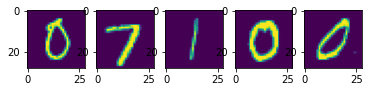

In [ ]:
# we create a loader to iterate through the dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       
                   ])),
    batch_size=args.batch_size, shuffle=True,drop_last=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=args.test_batch_size, shuffle=False,drop_last=True, **kwargs)

first_train_batch_imgs, first_train_batch_labels = next(iter(train_loader))
# set_trace()

f, axarr = pyplot.subplots(1,5)
for i in range(5):
  axarr[i].imshow(first_train_batch_imgs[i,0])
print(f'Labels of the shown images: {first_train_batch_labels[:5]}')


Train Convolutional network for MNIST classification.

In [ ]:
# define two functions, one for training the model and one for testing it

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    all_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # put the data on the GPU
        data, target = data.to(device), target.to(device)
        # initialize as zeros all the gradients of the model
        optimizer.zero_grad()
        
        # obtain the predictions in the FORWARD pass of the network
        output = model(data)
        # compute average LOSS for the current batch
        loss = F.nll_loss(output, target)
        all_losses.append(loss.detach().cpu().numpy())
        # BACKPROPAGATE the gradients
        loss.backward()
        # use the computed gradients to OPTIMISE the model
        optimizer.step()
        # print the training loss of each batch
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.array(all_losses).mean()

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        num_iter = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # obtain the prediction by a forward pass
            output = model(data)
            # calculate the loss for the current batch and add it across the entire dataset
            test_loss += F.nll_loss(output, target) # sum up batch loss
            # compute the accuracy of the predictions across the entire dataset
            # get the most probable prediction
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).float().mean().item()
            num_iter += 1
    test_loss /= num_iter
    test_accuracy = 100. * correct / num_iter
    # print the Accuracy for the entire dataset
    print('\nTest set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(
        test_loss,
        test_accuracy))
    return test_loss, test_accuracy

Create an optimizer and call the training / testing functions.

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298941
Train Epoch: 1 [9984/60000 (17%)]	Loss: 0.183366
Train Epoch: 1 [19968/60000 (33%)]	Loss: 0.142173
Train Epoch: 1 [29952/60000 (50%)]	Loss: 0.086569
Train Epoch: 1 [39936/60000 (67%)]	Loss: 0.077387
Train Epoch: 1 [49920/60000 (83%)]	Loss: 0.025256
Train Epoch: 1 [59904/60000 (100%)]	Loss: 0.028607

Test set: Average loss: 0.0686, Accuracy: (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.107286
Train Epoch: 2 [9984/60000 (17%)]	Loss: 0.039356
Train Epoch: 2 [19968/60000 (33%)]	Loss: 0.025075
Train Epoch: 2 [29952/60000 (50%)]	Loss: 0.025084
Train Epoch: 2 [39936/60000 (67%)]	Loss: 0.031149
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.012076
Train Epoch: 2 [59904/60000 (100%)]	Loss: 0.002799

Test set: Average loss: 0.0438, Accuracy: (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.035512
Train Epoch: 3 [9984/60000 (17%)]	Loss: 0.025323
Train Epoch: 3 [19968/60000 (33%)]	Loss: 0.048249
Train Epoch: 3 [29952/60000 (50%)]	Loss: 0.059074
Train Epoch: 3 [

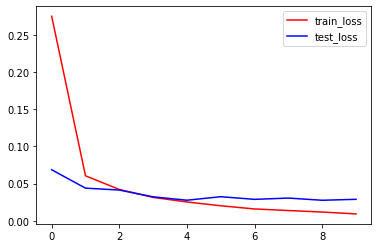

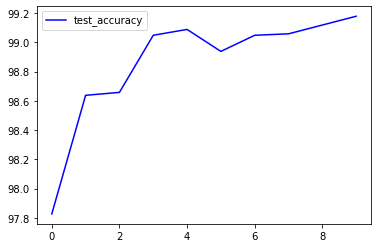

In [ ]:
def plot_loss(loss, label, color='blue'):
    pyplot.plot(loss, label=label, color=color)
    pyplot.legend()

# move the model to the GPU (when available)
model = CNN().to(device)
# create an Stochastic Gradient Descent optimiser
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

losses_train = []
losses_test = []
accuracy_test = []
for epoch in range(1, args.epochs + 1):
# for epoch in range(1, 3):
    train_loss = train(args, model, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test(args, model, device, test_loader)
    losses_train.append(train_loss)
    losses_test.append(test_loss)
    accuracy_test.append(test_accuracy)

#plot the loss/accuracy    
pyplot.figure(1)
plot_loss(losses_train,'train_loss','red')
plot_loss(losses_test,'test_loss')
pyplot.figure(2)
plot_loss(accuracy_test,'test_accuracy')

# save the final model
torch.save(model.state_dict(),"mnist_cnn.pt")




# > MNIST localisation 


---
Load loalisation dataset. It contains images of size $100 \times 100$ representing a single digit and random noise (given by small parts of digits). 
Our goal is to find the location of the center of the digit in every image.

np_dataset_large shape: (1000, 1, 100, 100)
np_dataset_large shape: (5000, 1, 100, 100)


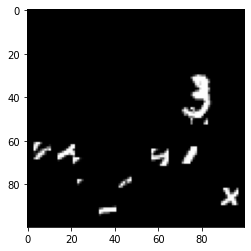

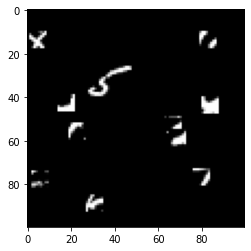

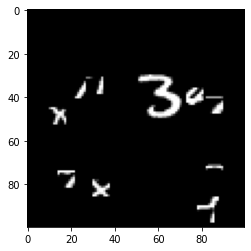

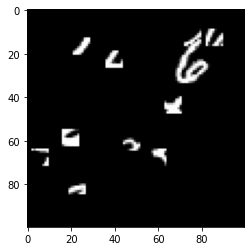

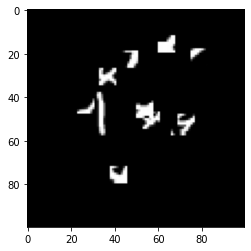

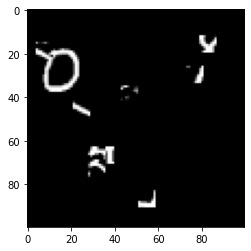

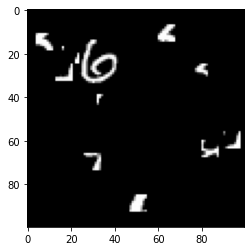

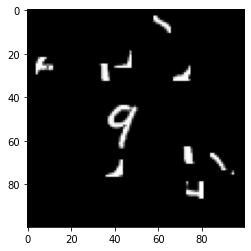

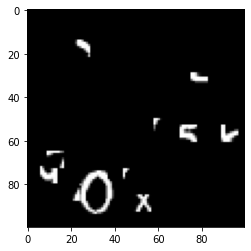

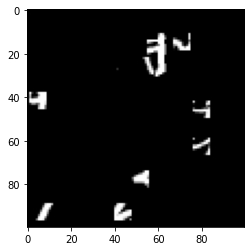

In [ ]:
import pickle

def get_large_dataset(path, max_batch_idx=100, shuffle=False,first_k=5000):
  # load the dataset as numpy arrays (tensors)
  with open(path,'rb') as handle:
    data = pickle.load(handle)
  # select only first_k elements in the dataset
  np_dataset_large  = np.expand_dims(data['images'],1)[:first_k]
  np_dataset_coords = data['coords'].astype(np.float32)[:first_k]
  
  # show a couple of examples from the dataset
  print(f'np_dataset_large shape: {np_dataset_large.shape}')
  for ii in range(5):
    example = np_dataset_large[10+ii].reshape((100, 100))
    pyplot.figure()
    pyplot.imshow(example, cmap="gray")
  
  # create loader from the numpy tensors
  from torch.utils.data import TensorDataset
  from torch.utils.data import DataLoader
  dataset_large, dataset_coords = map(torch.tensor, 
                (np_dataset_large, np_dataset_coords))
  dataset_large = dataset_large.to(device)
  dataset_coords = dataset_coords.to(device)

  large_dataset = TensorDataset(dataset_large, dataset_coords)
  large_data_loader = DataLoader(large_dataset, 
       batch_size=args.batch_size, shuffle=shuffle, drop_last=True)
  return large_data_loader

# create both train and test dataset
# TODO: change these paths to the place where the pickles are stored in you drive
path_train = '/content/gdrive/MyDrive/Copy of data_train.pickle'
path_test = '/content/gdrive/MyDrive/Copy of data_test.pickle'

large_data_loader_train = get_large_dataset(path_train,max_batch_idx=50,shuffle=True, first_k=1000)
large_data_loader_test = get_large_dataset(path_test,max_batch_idx=50)

We want to find the center of the digit in the image by taking advantage of our previous learned network for classification of 28x28 MNIST digits. 

---


Firstly, we will convert the network to run fully convolutional on larger 100x100 images. 

The simplest aproach is to run the previous network on  $28 \times 28$ patches in the bigger image, in a sliding window approach, calculating the output for every $28 \times 28$ patch (sub-window). But this is inefficient, as it recomputes many convolutional operations in two addiacent patches. 

For efficiency, we will  convert the network to run fully convolutional on larger 100x100 images. We do so by keeping all the conv layers, and convert all the fully connected layers into convolutional layers. For example the first fully connected layers that takes as input the liniarisation of features of size $4 \times 4 \times C$ would be converted with a convolutional layer with kernels of size 4.



This network would give us the same output as would the first classification network when run on a sliding window. 
Please note that the output resolution is smaller than the input, due to the stride=2 layers. We have 2 max-pooling layers, each with stride=2, so our output is al least 4 times smaller than the input. Due to usage of convolutions without padding, the size is even smaller. 


We will run this network on the larger 100x100 images and get 10 maps representing the probability that a digit is found at that location.
For every of the 10 feature maps (one for every class), we will select the feature map with the strongest activation, then we will find the location of this activation.

This gives us a good approximation of the location of the digit.


In [ ]:
# design the fully convolutional network   
# the first two conv layers should be the same as the original classification conv layers
# the last two conv layers should be transformed from the last two fully connected layers in the original network
class CNN_fully_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, no_filters1, 5, 1)
        self.conv2 = nn.Conv2d(no_filters1, no_filter2, 5, 1)
        self.fully_conv1  = nn.Conv2d(no_filter2,no_neurons1, 4)
        self.fully_conv2 = nn.Conv2d(no_neurons1,10, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.fully_conv1(x))
        x = self.fully_conv2(x)
        return F.log_softmax(x, dim=1)

Lets save the old classification model, and create a new fully convolutional model from the old parameters.

In [ ]:
# data should be in [0,1]
def preprocess(data):
  return data.float() / 255.0
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# save the classification model
PATH = 'conv_net.pt'
torch.save(model.state_dict(), PATH)

# define the fully_conv model
model_fuly_conv = CNN_fully_conv()

# load classification model
loaded_state_dict = torch.load(PATH)

# loaded_state_dict contain the weights of the classification model
# For the fully_conv model we will use exactly the same parameters.
# For the convolutional part we can directly load them as they have the same name.

# We need to convert the last fully-connected layers into convolutions
# For a single neuron we would just reshape the parameters from a vector into a kernel. 
# We just need to know what is the spatial dimension of the original fully-connected input.
# In our case, the first fully-connected had an input of size 4 x 4 x no_filter2, so we must use kernels of size 4 x 4 x no_filter2
# The second fully-connected receives as input just a vector(1x1 spatial dimension) of size no_neurons1 thus we use kernels of size 1 x 1 x no_neurons1
model_dict = {}
for key,val in loaded_state_dict.items():
  key = key.replace('fc','fully_conv')
  print(f'key: {key}')
  if 'fully_conv1.weight' in key:
    val = val.view(-1,no_filter2,4,4)
  if 'fully_conv2.weigh' in key:
    val = val.view(-1,no_neurons1,1,1)
  model_dict[key] = val
  
model_fuly_conv.load_state_dict(model_dict)
model_fuly_conv = model_fuly_conv.to(device)

print(model_fuly_conv.parameters)


    

Model's state_dict:
conv1.weight 	 torch.Size([20, 1, 5, 5])
conv1.bias 	 torch.Size([20])
conv2.weight 	 torch.Size([50, 20, 5, 5])
conv2.bias 	 torch.Size([50])
fc1.weight 	 torch.Size([500, 800])
fc1.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([10, 500])
fc2.bias 	 torch.Size([10])
key: conv1.weight
key: conv1.bias
key: conv2.weight
key: conv2.bias
key: fully_conv1.weight
key: fully_conv1.bias
key: fully_conv2.weight
key: fully_conv2.bias
<bound method Module.parameters of CNN_fully_conv(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fully_conv1): Conv2d(50, 500, kernel_size=(4, 4), stride=(1, 1))
  (fully_conv2): Conv2d(500, 10, kernel_size=(1, 1), stride=(1, 1))
)>


Lets evaluate this fully convolutional network. It is trained to recognize digits in the center of small $28 \times 28$ patches, and, when given input a larger $100 \times 100$ input it will result in a $19 \times 19$ map with 10 channels. A point in the k-th channel represents the probability that the digit k-1 is present in the image at a position coresponding to that point.


large_imgs shape torch.Size([64, 1, 100, 100])
Mean squared error: 0.24988070130348206
large_imgs shape torch.Size([64, 1, 100, 100])
Mean squared error: 0.24150528013706207
large_imgs shape torch.Size([64, 1, 100, 100])
Mean squared error: 0.23935379087924957
large_imgs shape torch.Size([64, 1, 100, 100])
Mean squared error: 0.2887684106826782
large_imgs shape torch.Size([64, 1, 100, 100])
Mean squared error: 0.3068154454231262
large_imgs shape torch.Size([64, 1, 100, 100])
Mean squared error: 0.2623642683029175
large_imgs shape torch.Size([64, 1, 100, 100])
Mean squared error: 0.27768146991729736
large_imgs shape torch.Size([64, 1, 100, 100])
Mean squared error: 0.24098965525627136
large_imgs shape torch.Size([64, 1, 100, 100])
Mean squared error: 0.21084819734096527
large_imgs shape torch.Size([64, 1, 100, 100])
Mean squared error: 0.3027017116546631
large_imgs shape torch.Size([64, 1, 100, 100])
Mean squared error: 0.2731609046459198
large_imgs shape torch.Size([64, 1, 100, 100])
M

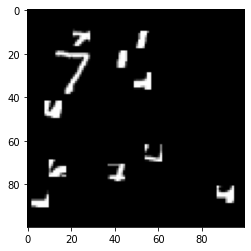

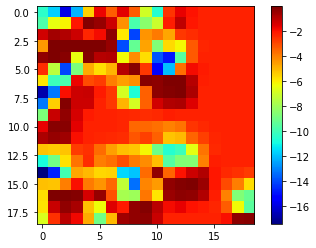

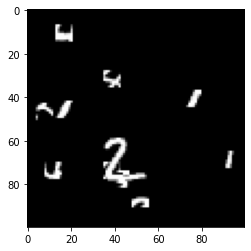

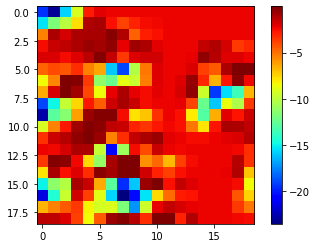

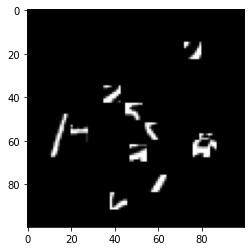

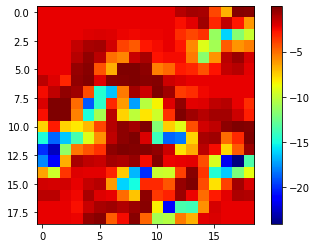

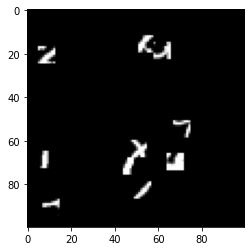

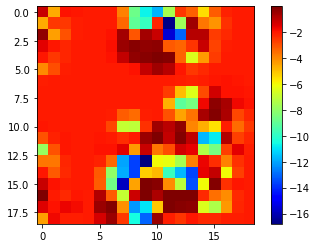

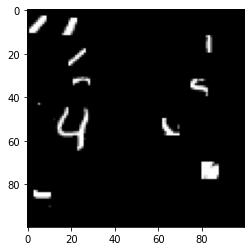

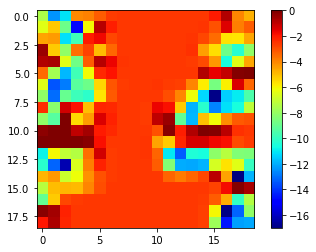

In [ ]:
# iterate over all the batches and estimate the location of the digit for each sample
for batch_idx, (large_imgs, target_coords) in enumerate(large_data_loader_test):
  print(f'large_imgs shape {large_imgs.shape}')
  large_imgs = preprocess(large_imgs)
  out_prob_maps = model_fuly_conv(large_imgs)
  # from the 10 maps, we select the index of the strongest activation
  max_ind = torch.argmax(torch.max(out_prob_maps.view(args.batch_size,10,-1),dim=2)[0],dim=1)
  # just for the first batch lets print some of the feature maps:
  if batch_idx == 0:
    for ii in range(5):
      pyplot.figure()
      pyplot.imshow(large_imgs[ii,0].cpu().detach().numpy(), cmap="gray")

      pyplot.figure()
      # pyplot.imshow(np.log(out_prob_maps[ii,max_ind[ii]].cpu().detach().numpy()), cmap="gray")
      pyplot.imshow(out_prob_maps[ii,max_ind[ii]].cpu().detach().numpy(), cmap="jet")
      pyplot.colorbar()
      
  all_locs = []
  # get the location of the maxim, for every example in batch
  # for this we linearise the selected map into a vector and find the maximum
  for i in range(args.batch_size):
    max_loc = torch.argmax(out_prob_maps[i,max_ind[i]])
    all_locs.append(max_loc)
  max_location = torch.stack(all_locs,dim=0)
  # compute the index in the original map from the index in the vector
  max_location_x = torch.unsqueeze(max_location / 19, dim=1).float()  / 19.0 
  max_location_y = torch.unsqueeze(max_location % 19, dim=1).float() / 19.0 
  coords = torch.cat([max_location_x,max_location_y],dim=1)
  # compute the error between the estimated location and the ground truth one
  mse = torch.mean(torch.sqrt(torch.sum((target_coords - coords) * (target_coords - coords),dim=1)))
  print(f'Mean squared error: {mse}')
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


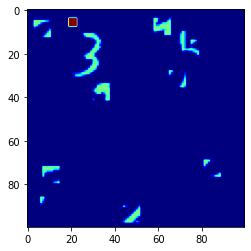

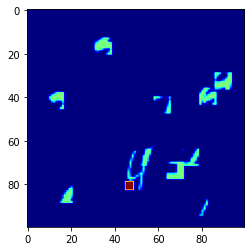

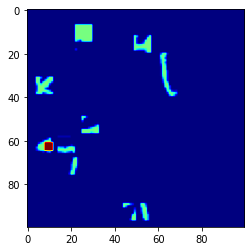

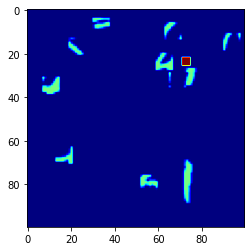

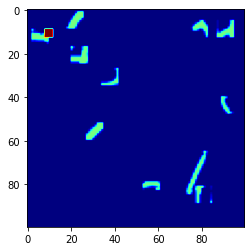

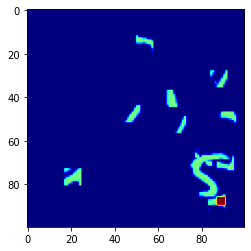

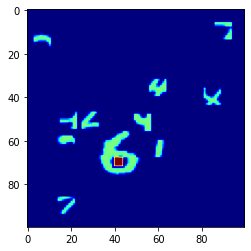

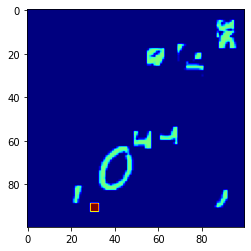

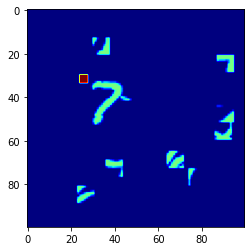

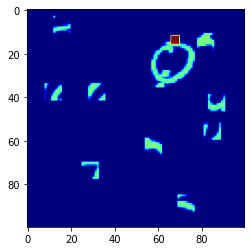

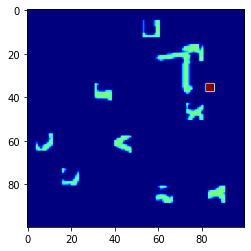

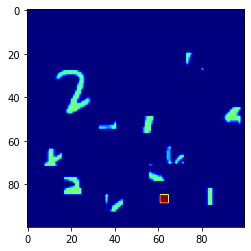

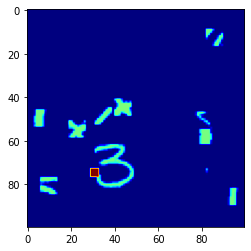

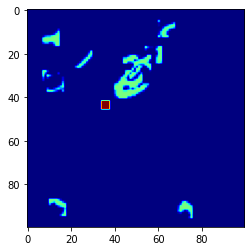

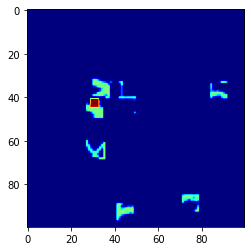

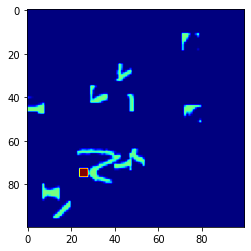

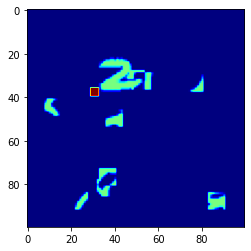

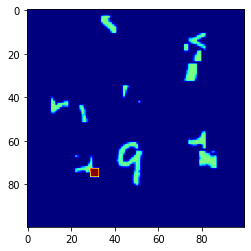

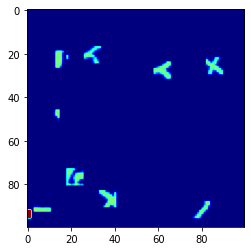

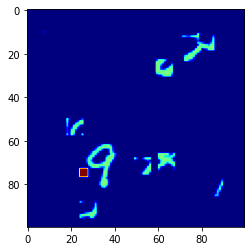

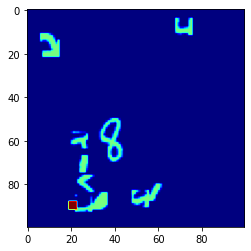

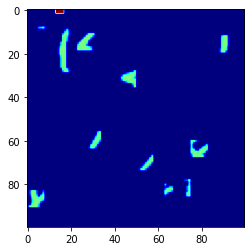

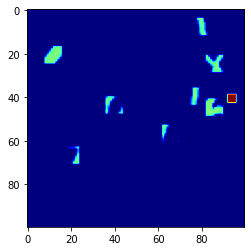

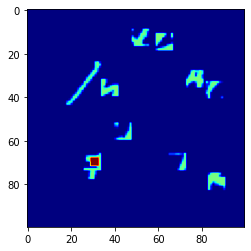

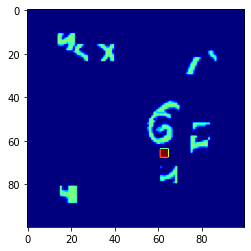

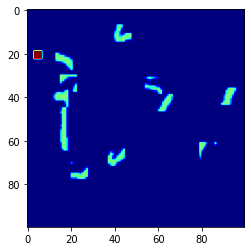

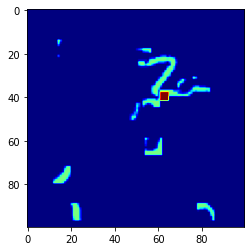

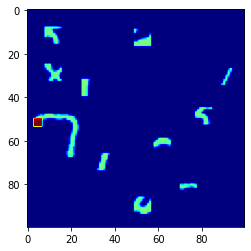

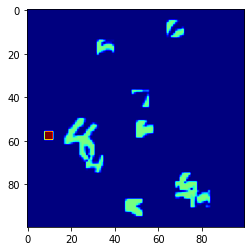

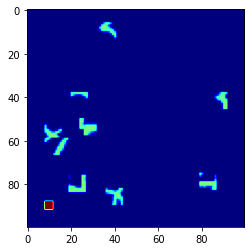

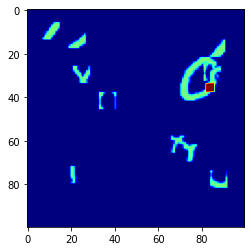

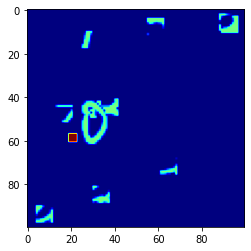

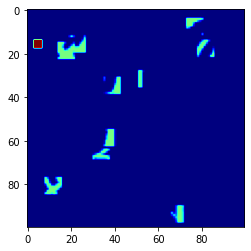

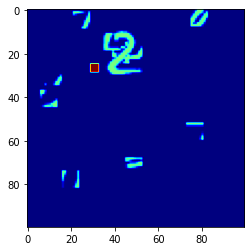

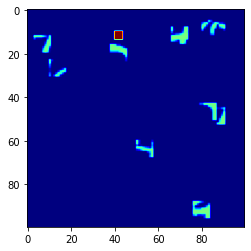

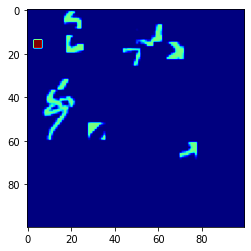

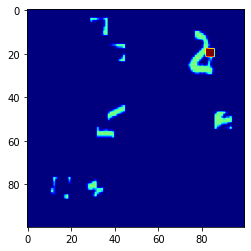

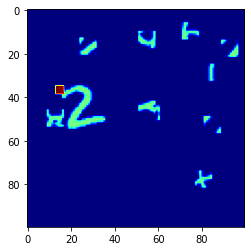

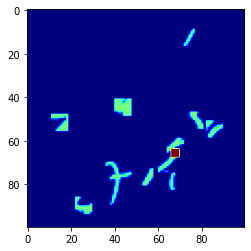

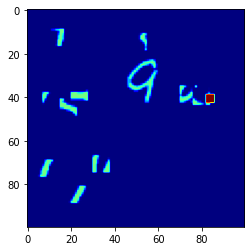

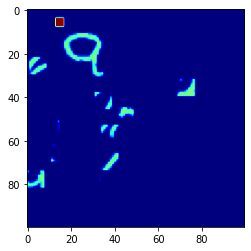

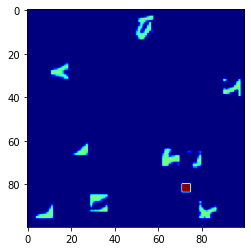

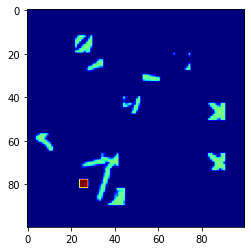

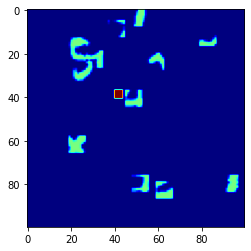

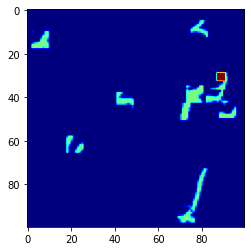

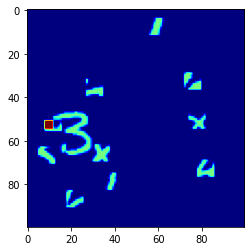

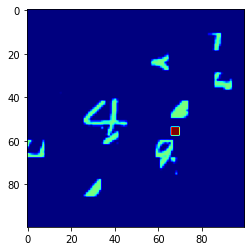

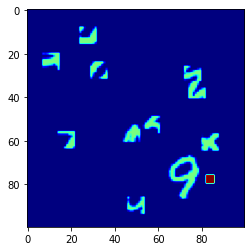

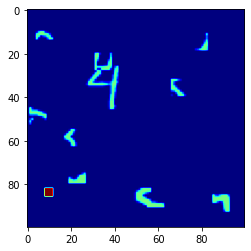

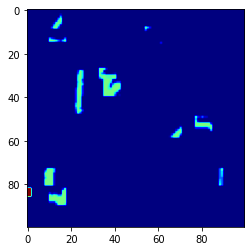

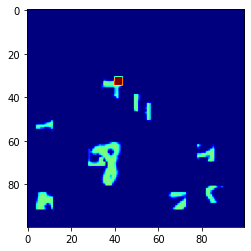

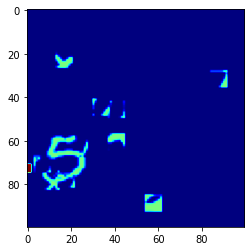

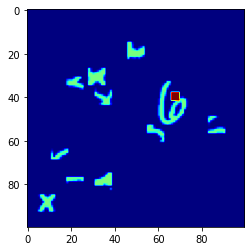

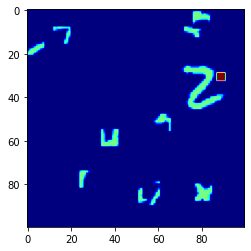

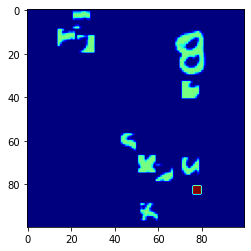

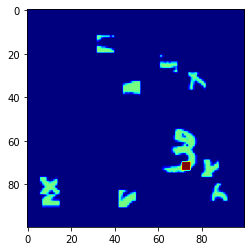

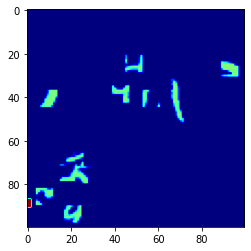

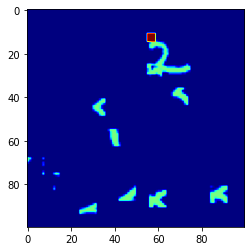

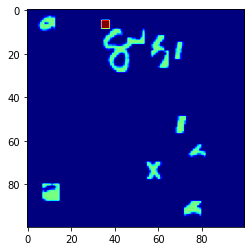

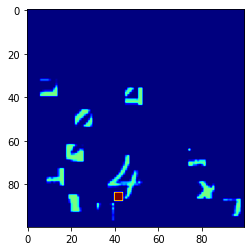

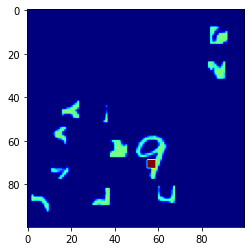

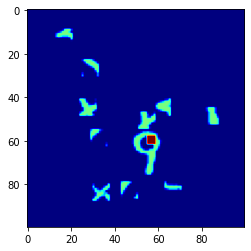

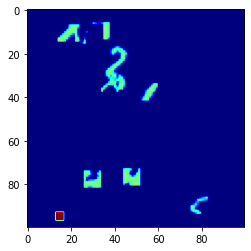

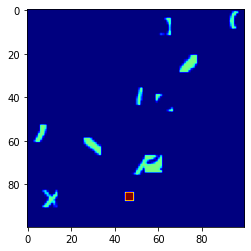

In [ ]:
# show some examples
# the center is represented as a sqare in the image
show_figures = True
if show_figures:
  for i in range(args.batch_size):
    pyplot.figure()
    img = large_imgs[i]
    center_l = (max_location_x[i] * 100).long()
    center_c = (max_location_y[i] * 100).long()

    #if center_l < 3 or center_c < 3:
    #  print(f'{center_l.cpu().detach().numpy()}, {center_c.cpu().detach().numpy()}')
    
    img[0,max(0,center_l-2):center_l+2,max(0,center_c-2):center_c+2] = 2
    pyplot.imshow(img.cpu().numpy().reshape((100, 100)), cmap="jet")

# Learn new localisation model.

Our previous method gives us a good approximation of the center of the digit, but we can improve this.

We will train a network to directly predict the center of the digit from the whole 100x100 image.
For this we will design a network similar with the original classification network that directly predict the coordinates of the center. The coordinates would be real numbers $\in [0,1]$. The first part of the localisation network will share the first part of the fully convolutional classification network, because we want to investigate how transfer learning works on this task.


In [ ]:
# design the localisation network
class CNN_localisation(nn.Module):
  def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1, no_filters1, 5, 1)
      self.conv2 = nn.Conv2d(no_filters1, no_filter2, 5, 1)
      self.fully_conv1  = nn.Conv2d(no_filter2,no_neurons1, 4)
      self.fully_conv2_new = nn.Conv2d(no_neurons1,10, 1)
      # add a linear layer 
      self.linear_loc = nn.Linear(19*19*10,2)
  def forward(self, xb):
      x = xb.view(-1, 1, xb.shape[2], xb.shape[3])
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.fully_conv1(x))
      self.conv_act = self.fully_conv2_new(x).view(args.batch_size,-1)
      self.lin = self.linear_loc(self.conv_act)
      self.sigm = F.sigmoid(self.lin)
      return self.sigm

In [ ]:
def plot_loss(loss, label, color='blue'):
    pyplot.plot(loss, label=label, color=color)
    pyplot.legend()
# train localisation model
def train_localisation(args, model, device, train_loader, optimizer, epoch):
    model.train()
    all_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = preprocess(data)
        optimizer.zero_grad()
        output = model(data)
        # as we want to predict real numbers, from a continuous space ([0,1])
        # we use mean-square-error loss (L2 loss)
        loss = F.mse_loss(output, target)
        
        loss.backward()
        all_losses.append(loss.data.cpu().numpy())
        optimizer.step()
        if False and batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.array(all_losses).mean()
def test_localisation(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        num_iter = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = preprocess(data)
            output = model(data)
            test_loss += F.mse_loss(output, target).item()
            num_iter += 1
    test_loss /= num_iter

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))
    return test_loss

We will train two variants of the network:

1. We randomly initialize the network and train it for the localisation task.  (from scratch)
2. We initialize the parameters from the previously trained classification network. (transfer learning)

Analyse the results both in terms of performance and how fast it starts to converge. 

key: conv1.weight
key: conv1.bias
key: conv2.weight
key: conv2.bias
key: fully_conv1.weight
key: fully_conv1.bias
key: fully_conv2.weight
key: fully_conv2.bias
Scratch epoch: 1


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Test set: Average loss: 0.0420

Scratch epoch: 2

Test set: Average loss: 0.0419

Scratch epoch: 3

Test set: Average loss: 0.0417

Scratch epoch: 4

Test set: Average loss: 0.0415

Scratch epoch: 5

Test set: Average loss: 0.0412

Scratch epoch: 6

Test set: Average loss: 0.0408

Scratch epoch: 7

Test set: Average loss: 0.0401

Scratch epoch: 8

Test set: Average loss: 0.0390

Scratch epoch: 9

Test set: Average loss: 0.0373

Scratch epoch: 10

Test set: Average loss: 0.0346

Scratch epoch: 11

Test set: Average loss: 0.0312

Scratch epoch: 12

Test set: Average loss: 0.0286

Scratch epoch: 13

Test set: Average loss: 0.0278

Scratch epoch: 14

Test set: Average loss: 0.0275

Scratch epoch: 15

Test set: Average loss: 0.0273

Scratch epoch: 16

Test set: Average loss: 0.0274

Scratch epoch: 17

Test set: Average loss: 0.0272

Scratch epoch: 18

Test set: Average loss: 0.0270

Scratch epoch: 19

Test set: Average loss: 0.0269

Scratch epoch: 20

Test set: Average loss: 0.0269

Scratc

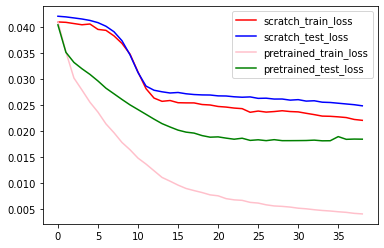

In [ ]:
# save classification model
PATH = 'conv_net.pt'
torch.save(model.state_dict(), PATH)

# we will train 2 models, one with random initialisation, 
# one with parameters initialised from the classification network
loc_model_scratch = CNN_localisation()
loc_model_pretrained = CNN_localisation()

# convert the fully-connected into convolutional layers
loaded_state_dict = torch.load(PATH)
model_dict = {}
for key,val in loaded_state_dict.items():
  key = key.replace('fc','fully_conv')
  print(f'key: {key}')
  if 'fully_conv1.weight' in key:
    val = val.view(-1,no_filter2,4,4)
  if 'fully_conv2.weigh' in key:
    val = val.view(-1,no_neurons1,1,1)
  model_dict[key] = val


loc_model_scratch = loc_model_scratch.to(device)
# load pretrained classification parameters into localisation model
loc_model_pretrained.load_state_dict(model_dict, strict=False)
loc_model_pretrained = loc_model_pretrained.to(device)


loc_model_pretrained.linear_loc.weight.data

optimizer_loc_scratch = optim.SGD(
    loc_model_scratch.parameters(), lr=args.lr, momentum=args.momentum)

optimizer_loc_pretrained = optim.SGD(
    loc_model_pretrained.parameters(), lr=args.lr, momentum=args.momentum)


losses_train = []
losses_test = []

for epoch in range(1, args.epochs + 30):
  
    print(f'Scratch epoch: {epoch}')
    train_loss = train_localisation(args, loc_model_scratch, device, large_data_loader_train, optimizer_loc_scratch, epoch)
    test_loss  = test_localisation(args, loc_model_scratch, device, large_data_loader_test)
    
    losses_train.append(train_loss)
    losses_test.append(test_loss)

losses_train_pre = []
losses_test_pre = []

for epoch in range(1, args.epochs + 30):
    print(f'Pretrained epoch: {epoch}')
    train_loss = train_localisation(args, loc_model_pretrained, device, large_data_loader_train, optimizer_loc_pretrained, epoch)
    test_loss  = test_localisation(args, loc_model_pretrained, device, large_data_loader_test)
    
    losses_train_pre.append(train_loss)
    losses_test_pre.append(test_loss)

    
plot_loss(losses_train,'scratch_train_loss','red')
plot_loss(losses_test,'scratch_test_loss')

plot_loss(losses_train_pre,'pretrained_train_loss','pink')
plot_loss(losses_test_pre,'pretrained_test_loss','green')